### MODEL LogisticRegression

##### IMPORT DES BIBLIOTHEQUES

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##### Dataframe

In [16]:
df = pd.read_csv("./../datasets/train.csv")

In [17]:
df = df.drop(columns=['id', 'CustomerId', 'Surname'], axis=1)

##### Séparation X / y

In [18]:
X = df.drop("Exited", axis=1)
y = df["Exited"]

##### SEPARATION DES COLONNES NUMERIQUES ET CATEGORIELLES

In [19]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

##### Préprocessing (encodage + standardisation)

In [20]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first"), cat_cols)
    ]
)

##### Train / Test split

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

##### Modèle  LOgistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

In [25]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", model)
])

In [26]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['Geography', 'Gender'], dtype='object'))])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [27]:
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

##### Evaluation du modèle

In [28]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[19775,  6248],
       [ 1856,  5128]])

In [29]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))
print("ROC-AUC :", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.91      0.76      0.83     26023
           1       0.45      0.73      0.56      6984

    accuracy                           0.75     33007
   macro avg       0.68      0.75      0.69     33007
weighted avg       0.82      0.75      0.77     33007

ROC-AUC : 0.8159123236167988


##### Le dataset présente un déséquilibre de classes avec environ 79% de clients non churn et 21% de churn. Ce déséquilibre justifie l’utilisation de métriques adaptées comme ROC-AUC et F1-score plutôt que l’accuracy seule.

##### Importance des variables selon le model Logististic Regression

In [37]:
# Récupérer les coefficients
coeffs = pipe.named_steps['model'].coef_[0]

# Récupérer les noms de features après transformation
ohe_columns = pipe.named_steps['preprocessing'].named_transformers_['cat'].get_feature_names_out(cat_cols)

# Transformer num_cols en liste
feature_names = list(num_cols) + list(ohe_columns)

# Créer le DataFrame et trier par importance
importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coeffs
}).sort_values(by='coefficient', key=abs, ascending=False)

print(importance)

              feature  coefficient
8   Geography_Germany     1.070975
1                 Age     0.871245
10        Gender_Male    -0.678074
6      IsActiveMember    -0.595095
4       NumOfProducts    -0.406964
5           HasCrCard    -0.085950
0         CreditScore    -0.060859
2              Tenure    -0.043216
7     EstimatedSalary     0.036461
3             Balance    -0.036129
9     Geography_Spain     0.027297


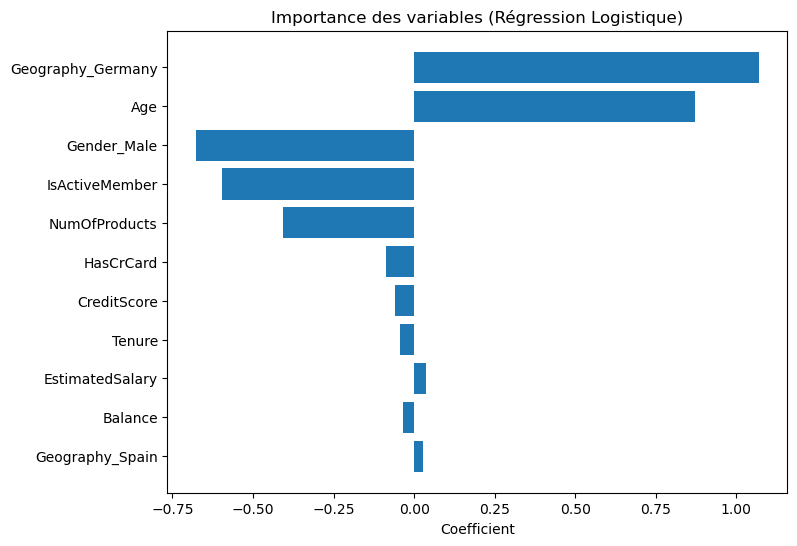

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.barh(importance['feature'], importance['coefficient'])
plt.xlabel("Coefficient")
plt.title("Importance des variables (Régression Logistique)")
plt.gca().invert_yaxis()  # pour avoir le plus important en haut
plt.show()

#### INTERPRETATION
* Geography_Germany	1.071	Être en Allemagne augmente fortement la probabilité de churn par rapport à la catégorie de référence (probablement France si encodage one-hot)
* Age	0.871	Les clients plus âgés ont plus de chances de churn (positif)
* Gender_Male	-0.678	Les hommes ont moins de chances de churn par rapport aux femmes
* IsActiveMember	-0.595	Les clients actifs ont moins de chances de churn
* NumOfProducts	-0.407	Plus le nombre de produits est élevé → moins de churn
* HasCrCard	-0.086	Posséder une carte de crédit réduit légèrement le churn
* CreditScore	-0.061	Coefficient très faible → impact négligeable
* Tenure	-0.043	Ancienneté faible impact sur churn
* EstimatedSalary	0.036	Salaire estimé quasi nul pour la prédiction
* Balance	-0.036	Solde du compte très faible impact
* Geography_Spain	0.027	Résident en Espagne : très faible effet comparé à la référence

##### DataFrame de comparaison du reel vs predit

In [ ]:
summary = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred,
    "y_proba": y_proba
})


In [ ]:
summary

,y_true,y_pred,y_proba
0,0,0,0.461488
1,1,0,0.128449
2,0,0,0.216250
3,0,1,0.565852
4,0,0,0.320329
...,...,...,...
33002,0,0,0.368164
33003,0,0,0.129372
33004,0,0,0.039695
33005,0,0,0.077917
